In [1]:
import geopandas as gpd
import human_compactness_utils as hc_utils
import sys
import distance_matrix
import rvp_utils
from tqdm import tqdm
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def read_duration_matrix_from_file(filename):
    dds = []
    with open(filename, 'r') as f:
        lines = f.readlines()
        for line in lines:
            dds.append([float(x) for x in line.split('  ')])
    return dds

def get_KNN_indices(pairwise_matrix, K, i):
    indices = sorted(list(enumerate(pairwise_matrix[i])), key=lambda x:x[1])
    return [index for (index, pairwise_TT) in indices[:K+1]]

def find_APTT_from_point(point, ids, pairwise_matrix):
    APTT = sum([pairwise_matrix[int(point)][int(other_point)] for other_point in ids])
    return APTT / (len(ids) - 1) # there are K+1 ids, including point

def find_APTT_of_region(ids, pairwise_matrix):
    APTT = sum([find_APTT_from_point(point, ids, pairwise_matrix) for point in ids])
    return APTT / len(ids) 

def return_rvp_ids(rvps):
    return [rvps.iloc[i].name for i in range(len(rvps))]

def find_avg_APTT_of_all_balls(ids, pairwise_matrix):
    APTT_of_balls = []
    for point in ids:
        KNNs_of_point = get_KNN_indices(pairwise_matrix, len(ids), point)
        APTT_of_ball = find_APTT_of_region(KNNs_of_point, pairwise_matrix)
        APTT_of_balls.append(APTT_of_ball)
    return np.mean(APTT_of_balls)

In [3]:
state_name = 'georgia'
state_fips = '13'
NUM_CDs = 13
DD_PATH = f'./20_intermediate_files/{state_fips}_{state_name}_tract_dds.json'
KNN_SUM_DM_PATH = f'./20_intermediate_files/{state_fips}_{state_name}_knn_sum_dd.dmx'
DM_PATH = f"./20_intermediate_files/duration_matrix_{state_name}_{state_fips}.dmx"
DURATION_DICT = hc_utils.read_tract_duration_json(DD_PATH)
SHAPEFILE_PATH = f'./Data_2000/Shapefiles/ga_2010_cds/ga_2010_cds.shp'
DEM_RVP_PATH = "RVPs/points_D_13_2_10000_run1.shp"
REP_RVP_PATH = "RVPs/points_R_13_2_10000_run1.shp"

In [4]:
print("Reading tract shapefile into memory...")
state_shp = gpd.read_file(SHAPEFILE_PATH)
# GA_07 = state_shp[state_shp["CD"] == "07"]

Reading tract shapefile into memory...


In [5]:
CDs = {}
for i in range(1,NUM_CDs+1):
    CD = "{0:0=2d}".format(i)
    CDs[i] = state_shp[state_shp["CD"] == CD]

In [6]:
print("Reading KNN_SUM duration matrix from memory...")
travel_time_matrix = read_duration_matrix_from_file(KNN_SUM_DM_PATH)

Reading KNN_SUM duration matrix from memory...


In [7]:
print("Reading pairwise duration matrix from memory...")
pairwise_matrix = read_duration_matrix_from_file(DM_PATH)

Reading pairwise duration matrix from memory...


In [8]:
print("Creating RVPs for each CD...")
rvps_in_CD = {}
rvps = rvp_utils.sample_rvps(DEM_RVP_PATH, REP_RVP_PATH, 14*1000)
# rvps_in_region = rvp_utils.find_rvps_in_region(state_shp, rvps)
for i in tqdm(range(1,NUM_CDs+1)):
    rvps_in_CD[i] = rvp_utils.find_rvps_in_region(CDs[i], rvps)

Creating RVPs for each CD...


/Users/gabe/miniconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
  8%|▊         | 1/13 [00:00<00:10,  1.18it/s]/Users/gabe/miniconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
 15%|█▌        | 2/13 [00:01<00:07,  1.54it/s]/Users/gabe/miniconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated.

In [11]:
district_APTTs = {}
for i in tqdm(range(1,NUM_CDs+1)):
    ids = return_rvp_ids(rvps_in_CD[i])
    district_APTTs[i] = find_APTT_of_region(ids, pairwise_matrix)

100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


sanity check to see which districts are which, and save stuff

In [12]:
district_APTTs

{1: 11156.78437732537,
 2: 9702.527348784894,
 3: 8126.350251768657,
 4: 2763.0481178374257,
 5: 3337.764071170826,
 6: 3947.2584704321475,
 7: 4047.619518139456,
 8: 8681.167452217478,
 9: 7945.897854719467,
 10: 7937.717834476381,
 11: 4572.552473890781,
 12: 10899.965784317774,
 13: 6295.972689604351}

Checking the APTT of GA-07

In [16]:
%%time
average_ball_APTTs = {}
for i in tqdm(range(1,NUM_CDs+1)):
    ids = return_rvp_ids(rvps_in_CD[i])
    average_ball_APTTs[i] = find_avg_APTT_of_all_balls(ids, pairwise_matrix)

100%|██████████| 13/13 [2:46:04<00:00, 766.53s/it]  

CPU times: user 59min 50s, sys: 1min 1s, total: 1h 52s
Wall time: 2h 46min 4s


^ the above should take ~40min * 13 = 9 hours

In [17]:
average_ball_APTTs

{1: 4879.312532550853,
 2: 4674.957948828636,
 3: 2990.0385342365857,
 4: 1262.941813209498,
 5: 1474.6949565452528,
 6: 1695.3510558350001,
 7: 2114.780797258487,
 8: 4434.260450606235,
 9: 2949.5270582061034,
 10: 2933.4593964552914,
 11: 1808.9823807459168,
 12: 3737.087727651739,
 13: 1749.1695166293796}

In [18]:
# pickle.dump(average_ball_APTTs, open("average_balls.p", "wb"))
# pickle.dump(district_APTTs, open("district_APTTs.p", "wb"))

In [9]:
average_ball_APTTs = pickle.load(open("average_balls.p", "rb"))
district_APTTs = pickle.load(open("district_APTTs.p", "rb"))

In [10]:
times = []
for i in range(1,NUM_CDs+1):
    print(f"CD {i}: district_APTT / average_ball_APTT = {district_APTTs[i]/average_ball_APTTs[i]}")
    times.append(district_APTTs[i]/average_ball_APTTs[i])

CD 1: district_APTT / average_ball_APTT = 2.2865484231428646
CD 2: district_APTT / average_ball_APTT = 2.075425587777955
CD 3: district_APTT / average_ball_APTT = 2.717807867263313
CD 4: district_APTT / average_ball_APTT = 2.187787346129373
CD 5: district_APTT / average_ball_APTT = 2.2633589789919393
CD 6: district_APTT / average_ball_APTT = 2.328283842362094
CD 7: district_APTT / average_ball_APTT = 1.913966460914824
CD 8: district_APTT / average_ball_APTT = 1.9577486593126532
CD 9: district_APTT / average_ball_APTT = 2.6939565896208957
CD 10: district_APTT / average_ball_APTT = 2.705923880885514
CD 11: district_APTT / average_ball_APTT = 2.5276932061689465
CD 12: district_APTT / average_ball_APTT = 2.9167005376047053
CD 13: district_APTT / average_ball_APTT = 3.5994068212076926


In [29]:
np.mean(times)

2.474969861644828

In [30]:
np.std(times)

0.44277794958873645

/Users/gabe/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'District APTT / Average Ball APTT')

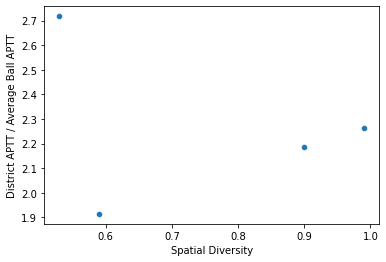

In [39]:
# Looking at GA-03, 04, 05, 07 (except for 03, all are not on boundary...)
factors = [district_APTTs[i]/average_ball_APTTs[i] for i in [3,4,5,7]]
spatials = [0.53, 0.90, 0.99, 0.59]
ax = sns.scatterplot(spatials, factors)
ax.set_xlabel("Spatial Diversity")
ax.set_ylabel("District APTT / Average Ball APTT")

In [34]:
factors

[2.717807867263313, 2.187787346129373, 2.2633589789919393, 1.913966460914824]